# Ratatoskr

## Dependecies

In [3]:

# Check if RocketPy is installed, and install it if missing
import importlib
import sys
import subprocess

package_name = "rocketpy"

try:
    importlib.import_module(package_name)
    print(f"{package_name} is already installed ✅")
except ImportError:
    print(f"{package_name} not found. Installing... ⏳")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
    print(f"{package_name} installed successfully ✅")


rocketpy is already installed ✅


In [4]:
from rocketpy import (
    Environment,
    SolidMotor,
    Rocket,
    Flight,
    TrapezoidalFins,
    RailButtons,
    NoseCone,
    Parachute,
)
import datetime
import operator
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('default')
#plt.style.use('dark_background')
'''
#Environment # Keeps data related to weather.
#Motor # Subdivided into SolidMotor, HybridMotor and LiquidMotor. Keeps data related to rocket motors.
#Rocket # Keeps data related to a rocket
#Flight # Runs the simulation and keeps the results.
'''

'\n#Environment # Keeps data related to weather.\n#Motor # Subdivided into SolidMotor, HybridMotor and LiquidMotor. Keeps data related to rocket motors.\n#Rocket # Keeps data related to a rocket\n#Flight # Runs the simulation and keeps the results.\n'

## Math Motor & Grains
# Volume of hollow cylinder:
$$ V = \pi \times h \times \left( r_{\text{outer}}^2 - r_{\text{inner}}^2 \right) $$

# Density:
$$ \rho = \frac{m}{V}  \Rightarrow $$
$$ \rho = \frac{m}{\pi \times h \times \left( r_{\text{outer}}^2 - r_{\text{inner}}^2 \right)} $$

# Inertia of hollow cylinder:

$$ I_x = I_y = \frac{1}{12} m \left( 3 r_{\text{inner}}^2 + r_{\text{outer}}^2 + L^2 \right) $$

$$ I_z = \frac{1}{2} m \left( r_{\text{inner}}^2 + r_{\text{outer}}^2 \right) $$


In [6]:
#Functions
def GetGrainInnerRadius():
    
    Mp = grain_p["prop_weight"]
    p = grain_p["grain_density"]
    r0 = grain_p["grain_outer_radius"]
    n = grain_p["grain_number"]
    h = grain_p["grain_initial_height"]
    Vtot = Mp/p
    Vg = Vtot/n
    A = Vg/h
    ri = r0**2 - A/np.pi
    ans = np.sqrt(ri)
    ans = float(round(ans,8))
    return ans

def GetGrainsCenterOfMassPosition():
    n = grain_p["grain_number"]
    h = grain_p["grain_initial_height"]
    gaps = n-1
    gap_length = grain_p["grain_separation"]
    full_stack = n * h + gaps * gap_length
    full_stack = float(round(full_stack/2,8))
    return full_stack



## Base parameters

In [8]:
#New numbers form ChatGPT, checked and seems to be correct
#https://cesaroni.net/products/p98-6gxl/21062o3400-p/
#https://www.thrustcurve.org/motors/Cesaroni/21062O3400-P/

motor_p = {
    "case_length": 1.239, #M, datacheet
    "outer_radius": 0.098/2, #M, datacheet
    "inner_radius": 0.047, #M, datacheet
    #"dry_mass": 5.360, # Motor casing + nozzle + internal components (ex fuel) (loaded weight - propellant weight)
    #"dry_mass": 16.842-10.930, #Loaded waight - prop waight, datacheet, 5.912
    "dry_mass": 5.570, #Using burnout mass form datacheet
    "center_of_dry_mass_position": lambda: motor_p["case_length"]/2, # case_length/2 
    "nozzle_radius": 0.03675,  # Exit radius of the nozzle in meters (outer  0.06858) (m)
    "throat_radius": 0.0245,  # Throat radius of the nozzle in meters (m)
    "nozzle_position": -0.06,
    "burn_time": (0.04, 6.16)  # Total burn time in seconds (s)
}

grain_p = {
    "prop_weight": 10.930, #Kg, datacheet
    "grain_number": 6,  # Number of propellant grains
    "grain_outer_radius": 0.098/2,  # Outer radius of each grain in meters (m)
    "grain_density": 1815,  #Kg/m^2 Guestimate, cheack other values(1700-1815)
    "grain_initial_height":0.1597,  # Height of each grain in meters (m)
    "grain_separation": 0.005,  # Separation between grains in meters (m)
}
grain_p["grain_initial_inner_radius"] = GetGrainInnerRadius()
grain_p["grains_center_of_mass_position"] = GetGrainsCenterOfMassPosition()

GetGrainsCenterOfMassPosition()
'''
def I_Hollow_Cylinder(m, r_inn, r_out, L):
    Ix = Iy = (m/12)*(3*r_inn**2 + r_out**2 + L**2)
    Iz = (m/2)*(r_inn**2 + r_out**2)
    return [Ix, Iy, Iz]
'''

# Defining inertia of motor

mI_x = mI_y = 1/12*motor_p["dry_mass"]*(3*(motor_p["outer_radius"]**2 + motor_p["inner_radius"]**2) + motor_p["case_length"]**2)
mI_z = 1/2*motor_p["dry_mass"]*(motor_p["outer_radius"]**2 + motor_p["inner_radius"]**2)

print(mI_x, mI_z)

0.7189714225000001 0.012838850000000002


## Motor

0.6195


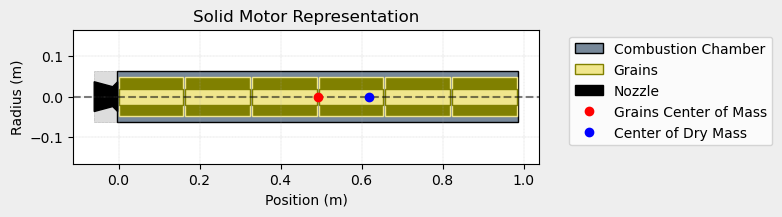

In [10]:
# Defining Motor object
# (denne er sjekket og )
Motor = SolidMotor(
    #thrust_source = "Cesaroni_21062O3400-P_thrust_curve.csv", ## CSV file or list [(time (s), thrust (N))] path/to/thrust_curve.csv
    thrust_source = "Cesaroni_21062O3400-P.eng",#https://www.thrustcurve.org/simfiles/5f4294d20002e900000007c0/
    dry_mass = motor_p["dry_mass"],
    center_of_dry_mass_position = motor_p["center_of_dry_mass_position"](), # "()" because of the lambda func
    nozzle_radius = motor_p["nozzle_radius"],
    throat_radius = motor_p["throat_radius"],
    nozzle_position = motor_p["nozzle_position"],
    burn_time = motor_p["burn_time"],
    dry_inertia = (mI_x, mI_y, mI_z),
    
    grain_number = grain_p["grain_number"],  # Number of propellant grains
    grain_density = grain_p["grain_density"],  # Density of propellant in kg/m³ (usikker på denne)
    grain_outer_radius = grain_p["grain_outer_radius"],  # Outer radius of each grain in meters (m)
    grain_initial_inner_radius = grain_p["grain_initial_inner_radius"],  # Initial inner radius of each grain in meters (m)
    grain_initial_height = grain_p["grain_initial_height"],  # Height of each grain in meters (m) (change this if n is changed to 7)
    grain_separation = grain_p["grain_separation"],  # Separation between grains in meters (m)
    grains_center_of_mass_position = grain_p["grains_center_of_mass_position"],  # Distance from nozzle exit to grain CoM (meters)
    
    coordinate_system_orientation = "nozzle_to_combustion_chamber"
)
print(Motor.center_of_dry_mass_position)
Motor.draw()
#Motor.plots.thrust()

## Math Rocket

# Inertia of cylinder:
$$ I_x = I_y = \frac{1}{12} m \left( 3 r^2 + h^2 \right) $$

$$ I_z = \frac{1}{2} mr^2 $$

# Parallel axis theorem:
$$ I = Icom + md^2 $$


## Rocket

In [13]:
# https://www.calcresource.com/moment-of-inertia-trap.html  
def I_Trapezoid(a, b, h):
    tI_x0 = (h**3/12)*(3*a*b)
    return tI_x0

# https://amesweb.info/inertia/mass-moment-of-inertia-cylinder.aspx
def I_Cylinder(m, r, h):
    cI_x = cI_y = (m/12)*(3*r**2+h**2)
    cI_z = (m*r**2)/2
    return [cI_x, cI_y, cI_z]

def Prallel_axis_theorem(Icom, m, d):
    I = Icom + m*d**2 
    return I

''' 
I = Moment of inertia about the new axis
Icom = Moment of inertia about the center of mass
m = Mass of the object
d = Distance between the COM and the new axis


z_n = 0 # nose = null point
z_cm = 1.94 # cm_pos
z_payload = 0.25/2 - z_cm #h/2 - z_cm

# I_cylinder(m, r, h) in kg, m, m
I_Payload = I_Cylinder(1.7, 0.0355, 0.25) # m_payload + m_bulkhead1 = 1.2 + 0.5 = 1.7, r_payload, h_payload 
I_Parachutes = I_Cylinder(1.091, 0.06, 0.2769) # main + drouge = 1.045 + 0.046, 0.06, main + drouge = 0.234 + 0.0429
I_MCRS = I_Cylinder(0.7, 0.048, 0.058) # 
I_HPRS = I_Cylinder(2.3, 0.25, 0.048) # m_HPRS + m_bulkhead2 = 2 + 0.3 = 2.3
I_Avionics = I_Cylinder(1, 0.05, 0.2) # 
I_AirFrame = 
# I_Finns = I_Trapezoid()

Ixy_Payload = Prallel_axis_theorem(I_Payload[0], 1.7, z_payload)
Ixy_Parachutes = Prallel_axis_theorem(I_Parachutes[0], 1.7, z_)
Ixy_MCRS = Prallel_axis_theorem(I_MCRS[0], 1.7, z)
Ixy_HPRS = Prallel_axis_theorem(I_HPRS[0], 1.7, z)
Ixy_Avionics = Prallel_axis_theorem(I_Avionics[0], 1.7, z)

Ixy_tot = Ixy_Payload + I
'''
# Defining Rocket object 
Ratatoskr = Rocket(
    inertia = (20.16459611, 20.16459642, 0.04881522), #Hentet fra Solidworks
    power_on_drag = r"mach_dragco_on.csv", #Begge hentet fra OpenRocket
    power_off_drag = r"mach_dragco_off.csv",
    radius = 0.128/2,  # Outer radius of the rocket body in meters (m)
    mass = 13.768,  # From OpenRocket, without motor, in kg 
    center_of_mass_without_motor = 1.43, #From OpenRocket (m)
    coordinate_system_orientation = "nose_to_tail"
)
Ratatoskr.add_motor(Motor, position = 2.97)  

In [14]:
# (dette er sjekket og korrekt)
railbuttons = Ratatoskr.set_rail_buttons(
    upper_button_position=2.15,
    lower_button_position=2.85,
    angular_position=300,
)

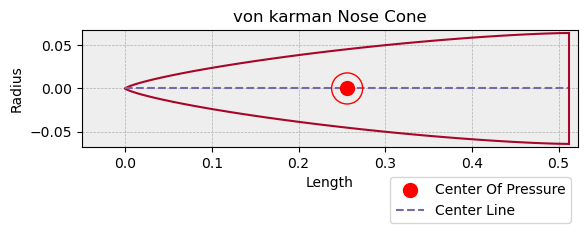

In [15]:
# (dette er sjekket og korrekt)
nose_cone = Ratatoskr.add_nose(
    length=0.512,
    kind="von karman",
    position=0
)
nose_cone.draw()

In [16]:
# Everything here is dummy info
'''
tail = Ratatoskr.add_tail(
    top_radius=0.0640,
    bottom_radius=0.0440,
    length=0.068,
    position=3
)
'''
#tail.all_info()

'\ntail = Ratatoskr.add_tail(\n    top_radius=0.0640,\n    bottom_radius=0.0440,\n    length=0.068,\n    position=3\n)\n'

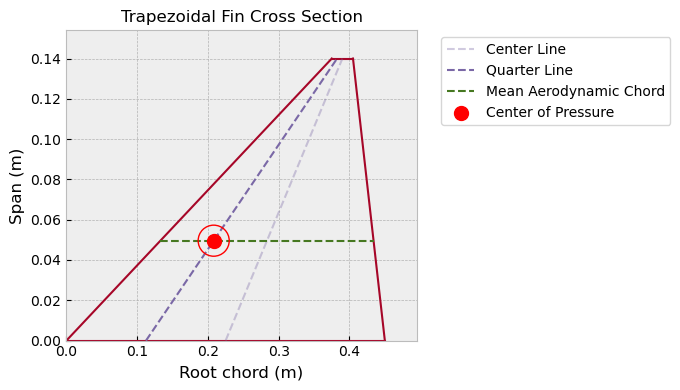

In [17]:
# Defining trapezodial fins
# (dette er sjekket og korrekt)
fins = Ratatoskr.add_trapezoidal_fins(
    n=4,  # Number of fins on the rocket
    root_chord=0.45,  # Length of the fin root (attached to the body) in meters (m)
    tip_chord=0.03,  # Length of the fin tip (outer edge) in meters (m)
    span=0.14,  # Distance from the rocket body to the fin tip in meters (Height) (m)
    sweep_length=0.375, # (m)
    position=2.52, #(m)
    cant_angle=0,  # Angle of fin tilt in degrees (0 means no cant)
)
fins.draw()

In [18]:
# Sufrace for camera bump
#camera_bump =
#RocketObj.add_surfaces(type = "bump")

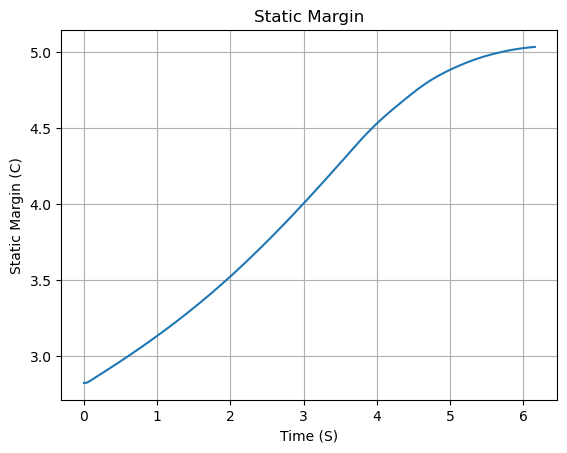

In [19]:
# Defining main chute
main = Ratatoskr.add_parachute(
    name="MainParachute",
    cd_s=23.116, # DragCoefficent*Area
    trigger= 450, # Deploy at decent @ 450m
    sampling_rate=100, # How often trigger condition is checked (Hz)
    lag=1.0, # Delay (seconds)
)

# Defining drouge chute
drouge = Ratatoskr.add_parachute(
    name="DrougeParachute",
    cd_s=0.452, # DragCoefficent*Area
    trigger= "apogee", 
    sampling_rate=100, # How often trigger condition is checked (Hz)
    lag=1.0,
)
#drouge.all_info()
#main.all_info()
Ratatoskr.plots.static_margin()
# Always check the static margin of your rocket.
# If it is negative, your rocket is unstable and the simulation will most likely fail.
# If it is unreasonably high, your rocket is super stable and the simulation will most likely fail.

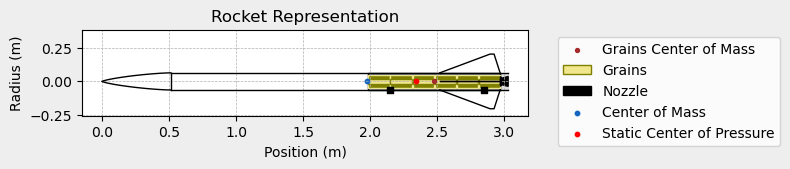

In [20]:
Ratatoskr.draw()
#RocketObj.center_of_mass()

## Environment

In [22]:
# Position of launch site @ Campo Militar de Santa Margarida (elevation of Constância)
#Utsira 59.307294, 4.865499
Env = Environment(
    latitude = 39.3897,
    longitude = -8.28896388889,
    #elevation = 37,
    timezone = "Portugal"
) 

Env.set_date(
    (2025, 10, 12, 12) # year, month, day, hour 
)  # Hour given in UTC time

#Env.set_atmospheric_model(type="standard_atmosphere")  # Standard atmosphere # type="Forecast", file="GFS"
wind_e = 6
wind_n = 0

Env.set_atmospheric_model(
    type = "custom_atmosphere",
    pressure = None, #Uses
    temperature = 300, # (K) (300K = 26.85C)
    wind_u = [ #east
        (0, wind_e), # x m/s @ x m
        (1000, wind_e)
    ],
    wind_v = [ #north
        (0, wind_n), # x m/s @ x m
        (1000, wind_n)
    ]
)


#Env.info()

## Flight

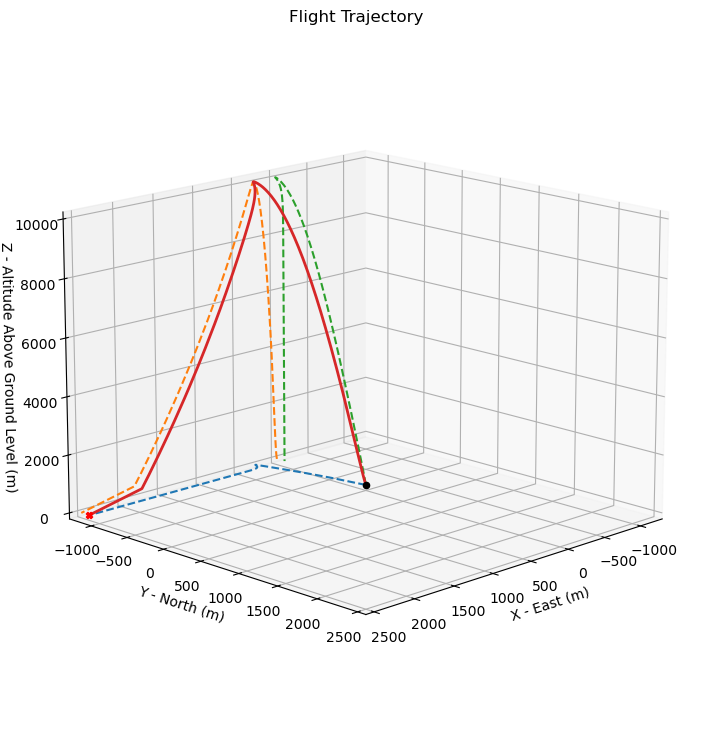

apogee: 10025.29m


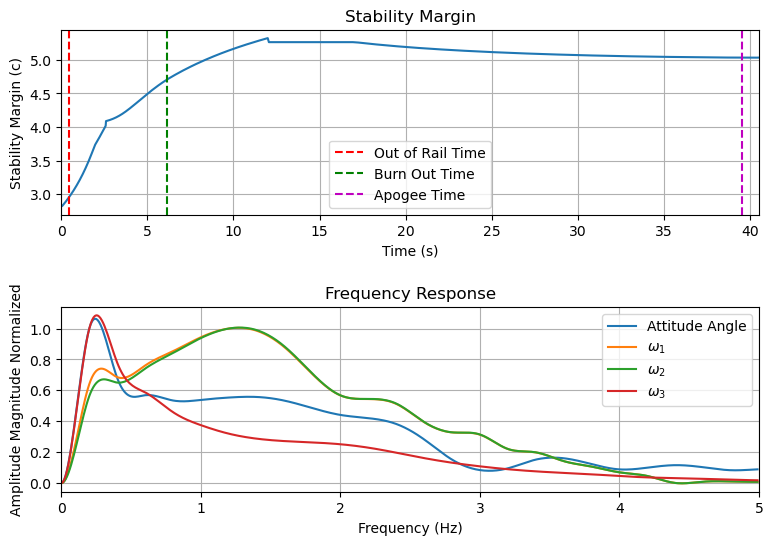


Rail Departure State

Rail Departure Time: 0.441 s
Rail Departure Velocity: 55.561 m/s
Rail Departure Stability Margin: 2.955 c
Rail Departure Angle of Attack: 6.196°
Rail Departure Thrust-Weight Ratio: 15.280
Rail Departure Reynolds Number: 4.516e+05

Burn out State

Burn out time: 6.160 s
Altitude at burn out: 2500.514 m (ASL) | 2500.514 m (AGL)
Rocket speed at burn out: 611.988 m/s
Freestream velocity at burn out: 611.938 m/s
Mach Number at burn out: 1.762
Kinetic energy at burn out: 3.621e+06 J
File  trajectory6msE-0msN.kml  saved with success!


In [24]:
'''
Ratatoskr_dict = { # With parachute
    "name": "ratatoskr",
    "rocket": Ratatoskr
}
Ballitoskr_dict = { # Ballistic
    "name": "Ballitoskr",
    "rocket": Ballitoskr
}
'''
# Add inertia calculation and loops for simulations 

# Inclination = launch angle relative to the ground (0° = horizontal, 90° = vertical)
testFlight = Flight(
    rocket=Ratatoskr, 
    environment=Env,
    rail_length=12, #(m)
    inclination=84, # Rail inclination angle (degrees from horizontal)
    heading=133 # Launch direction from Design Test Evluation Guide EuRoC 2026 Horizon.pdf
)

# compare flights
# rocket drift

#testFlight.all_info()
testFlight.plots.trajectory_3d()

print(f"apogee: {testFlight.apogee:.2f}m")
testFlight.plots.trajectory_3d(filename="trajectory_3d.jpg")
testFlight.plots.stability_and_control_data(filename="stability_and_control_data.jpg")
#testFlight.plots.rail_buttons_forces()
testFlight.plots.stability_and_control_data()
testFlight.prints.out_of_rail_conditions()
testFlight.prints.burn_out_conditions()
#testFlight.prints.max_mach()

testFlight.export_kml(
    file_name=f"trajectory{wind_e}msE-{wind_n}msN.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

